# Data Loading


In [1]:
df = spark.read.format("csv")\
    .option("header","true")\
    .option("inferschema","true")\
    .load("s3://vitaproject23/rawdata/")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1649397900626_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
df.select("*").show(5,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------

In [3]:
df.printSchema()
print("Number of Columns: ", len(df.columns))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: d

# Data Cleaning

Importing necessary libraries 

In [25]:
from pyspark.sql.functions import col,count,when,month,dayofweek,year


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We are taking into account only those flights which are not cancelled and not diverted because our aim is to predict delayed flights.

In [4]:
df.groupBy('CANCELLED').count().show(5,truncate=False)
df=df.where(col("CANCELLED")==0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+
|CANCELLED|count   |
+---------+--------+
|1.0      |973209  |
|0.0      |60583755|
+---------+--------+

In [5]:
df.groupBy('DIVERTED').count().show(5,truncate=False)

df=df.where(col("DIVERTED")==0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------+
|DIVERTED|count   |
+--------+--------+
|1.0     |145542  |
|0.0     |60438213|
+--------+--------+

# Drop Columns

Dropping Unnamed: 27 column because it is empty

In [6]:
df = df.drop('Unnamed: 27')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Since CANCLLED, CANCELLATION_CODE and DIVERTED columns are not related to flight delay hence we are droping them.

In [7]:
df=df.drop("CANCELLED","CANCELLATION_CODE","DIVERTED")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Dropping CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY columns because there are a lot of values missing values in these columns so this columns are not useful for prediction.

In [8]:
df=df.withColumn("FL_DATE",col("FL_DATE").cast("string"))
df.select([count(when( col(c).isNull(), c)).alias(c) for c in ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]).show()

df=df.drop('CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------+---------+--------------+-------------------+
|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+-------------+-------------+---------+--------------+-------------------+
|     49047473|     49047473| 49047473|      49047473|           49047473|
+-------------+-------------+---------+--------------+-------------------+

Dropping OP_CARRIER_FL_NUM column because they are unique in nature, hence we won't be using the flight number for predictions.

DEP_TIME and ARR_TIME columns are not going to help in prediction of flight delay at the time of booking ticket because customer is unaware of actual arrival and departure time.

In [9]:
df=df.drop('OP_CARRIER_FL_NUM','DEP_TIME', 'ARR_TIME')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Time-Related Columns

Time is normally a categorical and having it in the current format will give us too many columns when the hot encode is applied to them, therefore I will split the time into 4 quarters of the days meaning of 6 hours each.

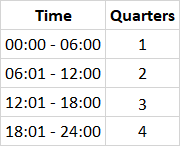


In [10]:

df=df.withColumn("CRS_DEP_TIME",col("CRS_DEP_TIME")/600).withColumn("WHEELS_OFF",col("WHEELS_OFF")/600).withColumn("WHEELS_ON",col("WHEELS_ON")/600).withColumn("CRS_ARR_TIME",col("CRS_ARR_TIME")/600)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:

df=df.withColumn("CRS_DEP_TIME",col("CRS_DEP_TIME").cast("int")).withColumn("WHEELS_OFF",col("WHEELS_OFF").cast("int")).withColumn("WHEELS_ON",col("WHEELS_ON").cast("int")).withColumn("CRS_ARR_TIME",col("CRS_ARR_TIME").cast("int"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Feature Engineering from Date Column

Based on FL_DATE column we are creating three new columns Month, Weekday and Year.
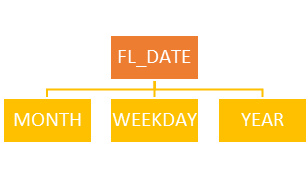

In [12]:

df = df.withColumn('MONTH',month(df.FL_DATE)).withColumn('WEEKDAY',dayofweek(df.FL_DATE)).withColumn('YEAR',year(df.FL_DATE))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Null Value Handling

Since very few null values (less than 0.01%) are present in the table hence we drop those flight records with null from table.

In [13]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+
|FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|MONTH|WEEKDAY|YEAR|
+-------+----------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+
|      0|         0|     0|   0|           1|     4725|       0|         0|        2|      1|           2|     2600|               2|                  3|       2|       0|    0|      0|   0|
+-------+----------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+

In [14]:
df = df.na.drop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
df.select([count(when( col(c).isNull(), c)).alias(c) for c in df.columns]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+
|FL_DATE|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|MONTH|WEEKDAY|YEAR|
+-------+----------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+
|      0|         0|     0|   0|           0|        0|       0|         0|        0|      0|           0|        0|               0|                  0|       0|       0|    0|      0|   0|
+-------+----------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+

# OP_CARRIER 

Changing the airline names to their extended names

In [16]:
df.select("OP_CARRIER").distinct().show(50,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|OP_CARRIER|
+----------+
|AS        |
|AA        |
|B6        |
|YV        |
|US        |
|MQ        |
|9E        |
|EV        |
|OO        |
|FL        |
|WN        |
|NW        |
|F9        |
|HA        |
|XE        |
|YX        |
|CO        |
|VX        |
|UA        |
|NK        |
|DL        |
|OH        |
|G4        |
+----------+

In [17]:
carrier_name = {'UA':'United Airlines',
    'AS':'Alaska Airlines',
    '9E':'Endeavor Air',
    'B6':'JetBlue Airways',
    'EV':'ExpressJet',
    'F9':'Frontier Airlines',
    'HA':'Hawaiian Airlines',
    'MQ':'Envoy Air',
    'NK':'Spirit Airlines',
    'OO':'SkyWest Airlines',
    'VX':'Virgin America',
    'WN':'Southwest Airlines',
    'YV':'Mesa Airline',
    'YX':'Republic Airways',
    'AA':'American Airlines',
    'US':'US Airways',
    'FL':'AirTran Airways Corporation',
    'NW':'Northwest Airlines',
    'CO':'Continental Air Lines',
    'XE':'Expressjet Airlines',
    'DL':'Delta Airlines',
    'OH':'Comair Airlines',
    'G4': 'Allegiant Airlines'}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
df = df.na.replace(carrier_name, 1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:1803: UserWarning: to_replace is a dict and value is not None. value will be ignored.

In [19]:
df.groupBy('OP_CARRIER').count().show(50,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------+--------+
|OP_CARRIER                 |count   |
+---------------------------+--------+
|United Airlines            |4756591 |
|Continental Air Lines      |732372  |
|Republic Airways           |305251  |
|Comair Airlines            |552941  |
|Mesa Airline               |1038742 |
|Virgin America             |384560  |
|Expressjet Airlines        |1074922 |
|ExpressJet                 |4575858 |
|SkyWest Airlines           |6131300 |
|Frontier Airlines          |894662  |
|JetBlue Airways            |2433733 |
|Northwest Airlines         |290097  |
|Allegiant Airlines         |95192   |
|Endeavor Air               |1030589 |
|American Airlines          |6553519 |
|Delta Airlines             |7763537 |
|Alaska Airlines            |1645358 |
|Spirit Airlines            |576161  |
|Hawaiian Airlines          |742923  |
|AirTran Airways Corporation|1203886 |
|Envoy Air                  |3094311 |
|US Airways                 |2616125 |
|Southwest Airlines      

# Target Variable

Creating a target variable FLIGHT_STATUS based on DEP_DELAY


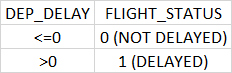

In [20]:
df = df.withColumn("FLIGHT_STATUS", when(df.DEP_DELAY <= 0 ,0)
                                    .otherwise(1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
df.groupBy('FLIGHT_STATUS').count().show(5,truncate=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------+
|FLIGHT_STATUS|count   |
+-------------+--------+
|1            |22204801|
|0            |38226219|
+-------------+--------+

In [22]:
df.select("*").show(5,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+-------------+
|FL_DATE            |OP_CARRIER         |ORIGIN|DEST|CRS_DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_DELAY|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|MONTH|WEEKDAY|YEAR|FLIGHT_STATUS|
+-------------------+-------------------+------+----+------------+---------+--------+----------+---------+-------+------------+---------+----------------+-------------------+--------+--------+-----+-------+----+-------------+
|2009-01-01 00:00:00|Expressjet Airlines|DCA   |EWR |1           |-2.0     |18.0    |1         |1        |8.0    |2           |4.0      |62.0            |68.0               |42.0    |199.0   |1    |5      |2009|0            |
|2009-01-01 00:00:00|Expressjet Airlines|EWR   |IAD |2           |-1.0     |28.0    |2         |

In [23]:
print("Number of Rows:", df.count())
print("Number of Columns:", len(df.columns))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Rows: 60431020
Number of Columns: 20

In [24]:
df.write.option("header","true").parquet("s3://group23project/data_cleaning/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…